# Example - Using Loman to value CDOs

In 2003, Andersen, Sidenius and Basu published their semi-analytic method for CDO tranche valuation in the paper ["All your hedges in one basket"](http://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/bf571acf7dbca8cbc12577b4001e3664/$FILE/JP%20Laurent%20Gr%C3%A9gory.pdf). For homogenous baskets, this gave sub-second valuations, and stable sensitivities. In this example, we go through calculating the value of a CDO tranche using this method.

First, a quick recap of the core of the method. Given a normally distributed random variable $M$, representing the state of the broad economy, and normally distributed random variable $Z_i$, representing the idiosyncratic performance of a set of indexed obligors $i=1, \ldots, N$, with $M$ and each $Z_i$ independent, we construct $X_i$:
$$ X_i = \sqrt{\rho} M + \sqrt{1-\rho} Z_i $$

We then have that each $X_i$ is normally distributed, and $\text{Corr}(X_i, X_j)=\rho$ where $i \ne j$.

In a simulation context we would simulate $M$ and each $Z_i$, and then take obligor $i$ as defaulted if $X_i$ fell below some threshold. However, conditional on $M$, the $X_i$s are independent, so given the conditional probability of default, calculating the loss distribution directly is a simple convolution and we can directly calculate the conditional probability by
$$P_\text{def}(i | M) 
= P\left( X_i < \Phi^{-1}(P_\text{def}(i)) | M \right) 
= \Phi\left( \frac{\Phi^{-1}(P_\text{def}(i)) - \sqrt{\rho}M}{\sqrt{1-\rho}} \right).$$

We now start our implementation by importing the usual modules, and creating an empty computation. Our goal will be to calculate the PVs of the default leg and the coupon leg (and hence the fair spread).

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats

import loman

norm = sp.stats.norm
import matplotlib.pyplot as plt

comp = loman.Computation()

The first thing to do is to work out the set of coupon times, so we create a node "ts" for this purpose. In this example, we simplify, by assuming that times can be represented as a number of years, and we ignore day count conventions, IMM payment dates and other details. To do this, we need the maturity and coupon frequency of the CDO. We then count back from maturity in steps of 1/freq. We remove the first coupon if the first coupon period would be too short, and we also add zero, although a coupon will not be paid at this time.

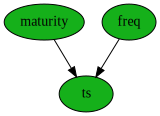

In [2]:
comp.add_node("maturity", value=5.0)
comp.add_node("freq", value=4)


@loman.node(comp)
def ts(maturity, freq, long_stub=True):
    per = 1.0 / freq
    ts = list(np.r_[maturity:0:-per])
    if (long_stub and ts[-1] < per - 0.0001) or ts[-1] < 0.0001:
        ts = ts[:-1]
    ts.append(0.0)
    ts.reverse()
    return np.array(ts)


comp.compute_all()
comp.draw()

And we can see that the vector of times is as we require:

In [3]:
comp.v.ts

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ])

Next, as we will be calculating PVs, we need the discount factor at each of these times. In this simple example, we take a fixed interest rate, applied continuously, to calculate discount factors. We might also choose to use a discount curve calibrated in the Loman Interest Rate Curve calibration example.

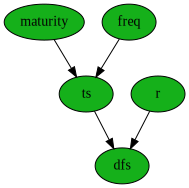

In [4]:
comp.add_node("r", value=0.04)


@loman.node(comp)
def dfs(ts, r):
    return np.exp(-r * ts)


comp.compute_all()
comp.draw()

We can also plot our wildly uninteresting discount factors to check they are reasonable:

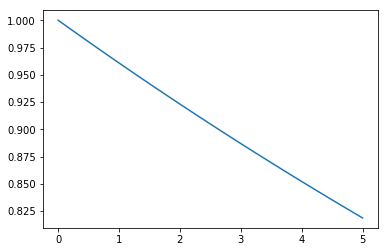

In [5]:
plt.plot(comp.v.ts, comp.v.dfs)

Next, we will need default probabilities for the obligors. In a more industrial-strength implementation, these would be calibrated to CDS and CDS index markets, but for our purposes, it is sufficient to use a simple approximation to determine a hazard rate that we will apply to all obligors.

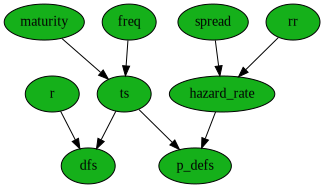

In [6]:
comp.add_node("spread", value=0.0060)
comp.add_node("rr", value=0.40)


@loman.node(comp)
def hazard_rate(spread, rr):
    return spread / (1.0 - rr)


@loman.node(comp)
def p_defs(hazard_rate, ts):
    return 1 - np.exp(-hazard_rate * ts)


comp.compute_all()
comp.draw()

And we plot the default probability for each obligor as a function of time, to check for reasonableness:

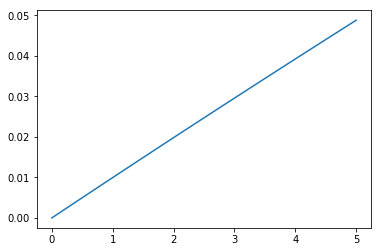

In [7]:
plt.plot(comp.v.ts, comp.v.p_defs)

In this model, we will be calculating the probability of a set of evenly spaced discrete levels of loss. Here, we create a node losses where each entry is the amount of loss at the CDO level associated with each state. In this example, each obligor is $\frac{1}{125}$th of the portfolio of \$10MM, with a recovery rate of 40%, so each loss is $48k. We create a column vector for convenience, as our loss distributions will have a row for each loss level, and a column for each coupon time.

In [8]:
comp.add_node("notional", value=10000000)
comp.add_node("n_obligors", value=125)
comp.add_node("n_losses", lambda n_obligors: n_obligors)


@loman.node(comp)
def lgd(rr):
    return 1.0 - rr


@loman.node(comp)
def losses(notional, n_losses, n_obligors, lgd):
    loss_amount = notional * 1.0 / n_obligors * lgd
    return (np.arange(n_losses) * loss_amount)[:, np.newaxis]


comp.compute_all()
comp.v.losses.T

array([[       0.,    48000.,    96000.,   144000.,   192000.,   240000.,
          288000.,   336000.,   384000.,   432000.,   480000.,   528000.,
          576000.,   624000.,   672000.,   720000.,   768000.,   816000.,
          864000.,   912000.,   960000.,  1008000.,  1056000.,  1104000.,
         1152000.,  1200000.,  1248000.,  1296000.,  1344000.,  1392000.,
         1440000.,  1488000.,  1536000.,  1584000.,  1632000.,  1680000.,
         1728000.,  1776000.,  1824000.,  1872000.,  1920000.,  1968000.,
         2016000.,  2064000.,  2112000.,  2160000.,  2208000.,  2256000.,
         2304000.,  2352000.,  2400000.,  2448000.,  2496000.,  2544000.,
         2592000.,  2640000.,  2688000.,  2736000.,  2784000.,  2832000.,
         2880000.,  2928000.,  2976000.,  3024000.,  3072000.,  3120000.,
         3168000.,  3216000.,  3264000.,  3312000.,  3360000.,  3408000.,
         3456000.,  3504000.,  3552000.,  3600000.,  3648000.,  3696000.,
         3744000.,  3792000.,  3840000

We will also need the amount of the tranche remaining in each state, with the attachment and detachment points provided as a percentage of portfolio notional, again as a column vector:

In [9]:
comp.add_node("ap", value=0.03)
comp.add_node("dp", value=0.06)


@loman.node(comp)
def tranche_widths(notional, losses, ap, dp):
    return np.maximum(losses, dp * notional) - np.maximum(losses, ap * notional)


comp.compute_all()
comp.v.tranche_widths.T

array([[ 300000.,  300000.,  300000.,  300000.,  300000.,  300000.,
         300000.,  264000.,  216000.,  168000.,  120000.,   72000.,
          24000.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

Ok, now we get to calculating leg PVs conditional on $M$. We make a node `M`, which is an input which we will vary exogenously. The first thing to calculate is the condition default probabilities of each obligor. However, in this example, every obligor has the same default probability and hence the same conditional default probability:

In [10]:
comp.add_node("corr", value=0.35)
comp.add_node("M", value=0)


@loman.node(comp)
def p_def_conds(M, p_defs, corr):
    return norm.cdf((norm.ppf(p_defs) - np.sqrt(corr) * M) / np.sqrt(1 - corr))

Next we calculate the loss distribution, in a node `ps`. Rather than the recursion given by Andersen et al, we use Parcell's [Loss unit interpolation](http://www.edparcell.com/lossdistint.pdf) method, which copes better with fractional losses. The node `ps` is a vector with dimensions $\text{number of loss levels} \times \text{number of coupon times}$. We first initialize it so that the zero loss level has probability 1 at each coupon time, and every other level has probability 0. We then update the loss distribution in a loop, adding each obligor in turn, and updating the loss distribution accordingly:

In [11]:
def init_loss_distribution(n_losses, n_ts):
    ps = np.zeros((n_losses, n_ts))
    ps[0, :] = 1.0
    return ps


def update_loss_distribution(ps, p_default, loss):
    """ps: float[n_losses, n_ts]
    p_default: float | float[n_ts]
    loss: float.
    """
    ps1 = ps.copy()
    loss_lower = int(loss)
    loss_upper = loss_lower + 1
    loss_frac = loss - loss_lower
    ps *= 1 - p_default
    ps[loss_lower:] += p_default * (1 - loss_frac) * ps1[:-loss_lower]
    ps[loss_upper:] += p_default * loss_frac * ps1[:-loss_upper]


@loman.node(comp)
def ps(n_losses, ts, n_obligors, p_def_conds):
    ps = init_loss_distribution(n_losses, len(ts))
    for i in range(n_obligors):
        update_loss_distribution(ps, p_def_conds, 1)
    return ps


comp.compute_all()

Having calculated the conditional loss distribution, we can see how it evolves over time:

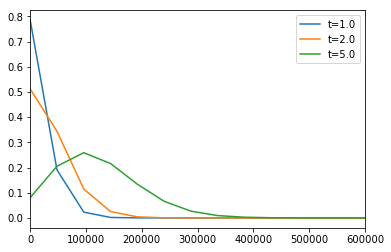

In [12]:
plt.plot(comp.v.losses[:, 0], comp.v.ps[:, 4], label=f"t={comp.v.ts[4]}")
plt.plot(comp.v.losses[:, 0], comp.v.ps[:, 8], label=f"t={comp.v.ts[8]}")
plt.plot(comp.v.losses[:, 0], comp.v.ps[:, 20], label=f"t={comp.v.ts[20]}")
plt.xlim(0, 600000)
plt.legend()

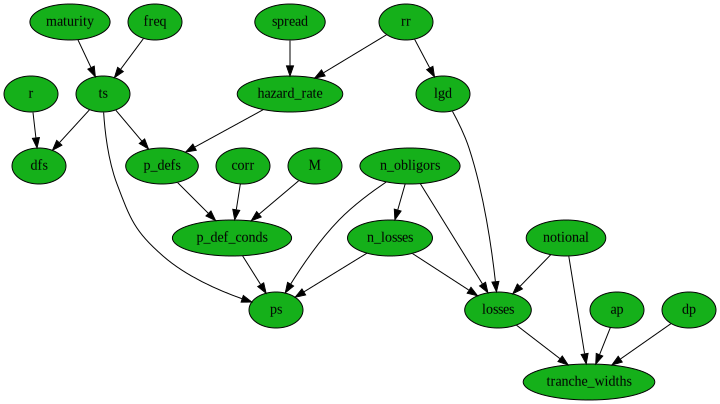

In [13]:
comp.draw()

We now have the probability of being in each loss level at each time, and the associated tranche width in that loss state, so we can calculate and plot the conditional expected tranche width over time:

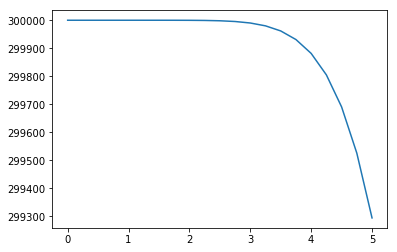

In [14]:
@loman.node(comp)
def expected_tranche_widths(ps, tranche_widths):
    return np.sum(ps * tranche_widths, axis=0)


comp.compute_all()
plt.plot(comp.v.ts, comp.v.expected_tranche_widths)

The conditional expected default leg is calculated as the change in conditional expected tranche width with discounting applied:

In [15]:
@loman.node(comp)
def default_amounts(expected_tranche_widths):
    return -np.diff(expected_tranche_widths)


@loman.node(comp)
def default_leg_pv(default_amounts, dfs):
    return np.sum(default_amounts * dfs[1:])

We make the approximation that coupon is paid on a notional that is the average of tranche width at the start and end of the coupon peried. Discounting is applied, and we calculate the PV of paying a 100% running coupon (!) for convenience calculating the fair spread later, and also the coupon paying a fixed level coupon, which is an input

In [16]:
@loman.node(comp)
def average_tranche_widths(expected_tranche_widths):
    return (expected_tranche_widths[:-1] + expected_tranche_widths[1:]) / 2.0


@loman.node(comp)
def coupon_leg_1_pv(average_tranche_widths, dfs, ts):
    return np.sum(average_tranche_widths * dfs[1:] * np.diff(ts))


comp.add_node("coupon", value=0.05)


@loman.node(comp)
def coupon_leg_pv(coupon, coupon_leg_1_pv):
    return coupon * coupon_leg_1_pv

We now have a reasonably complex graph, which represents calculating conditional default probability:

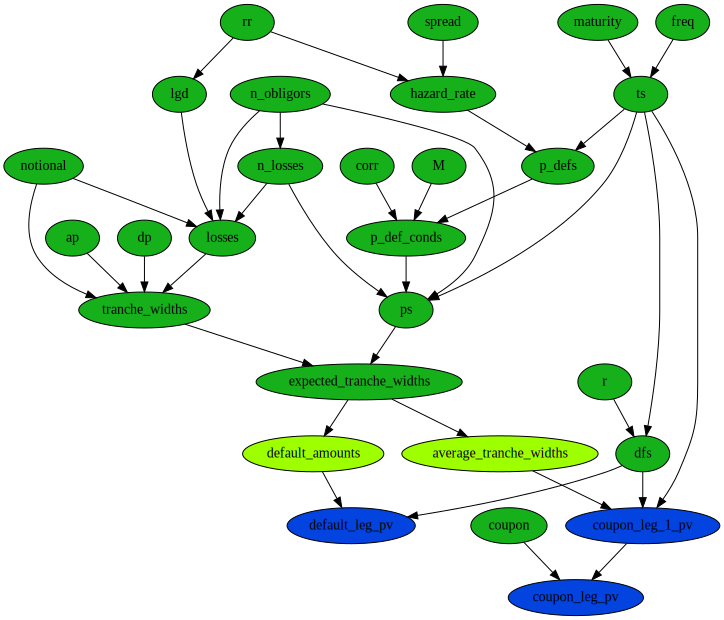

In [17]:
comp.draw(show_expansion=True)

To calculate the (unconditional) leg PVs, we loop over various values of $M$, summing weighted conditional leg PVs. Here we use Gauss-Hermite, although other numerical integration schemes, from the trapezoid rule to adaptive methods are also possible. We would caution against using adaptive methods when calculating sensitivities however, as then perturbed results will incorporate changes in decisions made by the adaptive methods, as well as those resulting directly from changes to the inputs.

Note how Loman is convenient in a couple of ways here. First, we do not have to worry about which things need to be recalculated and which don't as we change $M$. In fact, with extensions like stochastic recovery rates, it can become unclear which things even need to be recalculated, but that is automatically tracked. Second, Loman makes it easy to pull out multiple end or intermediate results. Here we extract three leg PVs.

In [18]:
n_abscissas = 40
Ms, ws = np.polynomial.hermite.hermgauss(n_abscissas)
Ms *= np.sqrt(2)
ws /= np.sqrt(np.pi)
default_leg_pv = 0
coupon_leg_1_pv = 0
coupon_leg_pv = 0
for M, w in zip(Ms, ws):
    comp.insert("M", M)
    comp.compute_all()
    default_leg_pv += w * comp.v.default_leg_pv
    coupon_leg_1_pv += w * comp.v.coupon_leg_1_pv
    coupon_leg_pv += w * comp.v.coupon_leg_pv

And below are the unconditional leg PVs, and fair spread for this tranche. We note that using Loman did not significantly effect the computation time, and the method remains efficient.

In [19]:
default_leg_pv

56375.857118949913

In [20]:
coupon_leg_pv

61295.668803795743

In [21]:
default_leg_pv / coupon_leg_1_pv

0.045986819476108581

Finally, for fun, we use Loman's flexibility in exposing intermediate results to calculate an unconditional loss distribution, and plot how that evolves over time:

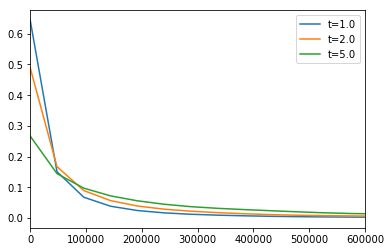

In [22]:
n_abscissas = 40
Ms, ws = np.polynomial.hermite.hermgauss(n_abscissas)
Ms *= np.sqrt(2)
ws /= np.sqrt(np.pi)
ps = None
for M, w in zip(Ms, ws):
    comp.insert("M", M)
    comp.compute_all()
    if ps is None:
        ps = np.zeros_like(comp.v.ps)
    ps += comp.v.ps * w

plt.plot(comp.v.losses[:, 0], ps[:, 4], label=f"t={comp.v.ts[4]}")
plt.plot(comp.v.losses[:, 0], ps[:, 8], label=f"t={comp.v.ts[8]}")
plt.plot(comp.v.losses[:, 0], ps[:, 20], label=f"t={comp.v.ts[20]}")
plt.xlim(0, 600000)
plt.legend()